# Real-time adaptive filtering using least-mean-squares (LMS)

This notebook tests a Python implementation of the [least-mean-squares (LMS) filter](https://en.wikipedia.org/wiki/Least_mean_squares_filter) on two types of synthetic data and the test signal used for the filter latency tests (see previous notebook). 

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import uniform_filter1d

## Random number generator

In [2]:
rng = np.random.default_rng(12345)

## Implement LMS filter for multidimensional signal

The code below was adapted from the [`padasip`](http://matousc89.github.io/padasip/) library, and is identical to the code used to implement the filter in the Python prototype (`python/realtime.py`). It defines two classes: `FilterLMS`, which implements a basic LMS filter, and `FilterAutoLMS`, which uses an LMS filter for the specific task of predicting the next value in an autoregressive process.

Some of this code, especially in the `FilterLMS` class, was adapted from the [`padasip`](http://matousc89.github.io/padasip/) package, a Python library for adaptive signal processing. The functions in `padasip` only work with 1-D signals, and because our signal is multidimensional, we needed to create our own modification.

In [3]:
class FilterLMS:
    """This class represents an adaptive LMS filter.
    
    Args:
        dim (int): Dimension of signal
        order (int): Order of filter
        mu (float, optional): Learning rate. Also known as step size. If it is
            too slow, the filter may have bad performance. If it is too high,
            the filter will be unstable. The default value can be unstable for
            ill-conditioned input data.
        wts_init (str, optional): Method for initializing weights. Options are:
            - 'random': Create random weights
            - 'zeros': Create zero value weights
    """
    
    def __init__(self, dim, order, mu=0.01, wts_init='random'):
        
        self.dim = self._check_int_param(dim, 0, None)
        self.order = self._check_int_param(order, 0, None)
        self.mu = self._check_float_param(mu, 0, 1000)
        self.wts_shape = (self.dim, self.order * self.dim)
        
        if wts_init == 'random':
            self.wts = np.random.normal(0, 0.5, self.wts_shape)
        elif wts_init == 'zeros':
            self.wts = np.zeros(self.wts_shape)
        else:
            raise ValueError(f'"{wts_init}" not valid option for weight init')
        
    @staticmethod
    def _check_int_param(param, lo, hi):
        """Check if parameter is int and within given range.
        
        Args:
            param (convertible to int): Parameter to check
            lo (int): Lowest allowed value, or None
            hi (int): Highest allowed value, or None
            
        Returns:
            (int): Parameter converted to int
        """
        
        try:
            param = int(param)            
        except ValueError:
            raise ValueError('Parameter is not int or similar')
        else:
            if lo is None:
                lo = float('-inf')
            if hi is None:
                hi = float('inf')
            if not lo <= param <= hi:
                raise ValueError('Parameter is not in range')
            return param
    
    @staticmethod
    def _check_float_param(param, lo, hi):
        """Check if parameter is float and within given range.
        
        Args:
            param (convertible to float): Parameter to check
            lo (float): Lowest allowed value, or None
            hi (float): Highest allowed value, or None
            
        Returns:
            (float): Parameter converted to float
        """
        
        try:
            param = float(param)            
        except ValueError:
            raise ValueError('Parameter is not float or similar')
        else:
            if lo is None:
                lo = float('-inf')
            if hi is None:
                hi = float('inf')
            if not lo <= param <= hi:
                raise ValueError('Parameter is not in range')
            return param
    
    @staticmethod
    def _input_to_vec(x):
        """Convert input matrix to vector."""
        
        return x.T.reshape(-1, 1)
        
    def adapt(self, d, x):
        """Adapt weights using desired value and its input.
        
        Args:
            d (dim*1 array): Desired value
            x (dim*order array): Input array
        """

        x_vec = self._input_to_vec(x)

        y = self.wts @ x_vec
        e = d - y
        self.wts += self.mu * e * x_vec.T 

    def predict(self, x):
        """Predict output for given input using current filter state.
        
        Args:
            x (dim*order array): Filter input matrix. Each column is a signal
                value for a given time.
        Returns:
            (dim*1 array): Output vector.
        """
        
        return self.wts @ self._input_to_vec(x)


class FilterAutoLMS:
    """This class implements a LMS filter on an autoregressive process.

    It maintains a history of signal values of size `order`, and uses this
    history as the input for the LMS filter, which is trained to predict the
    next value of the time series.
    
    Args:
        dim (int): Dimension of signal
        order (int): Order of filter
        mu (float, optional): Learning rate. Also known as step size. If it is
            too slow, the filter may have bad performance. If it is too high,
            the filter will be unstable. The default value can be unstable for
            ill-conditioned input data.
        wts_init (str, optional): Method for initializing weights. Options are:
            - 'random': Create random weights
            - 'zeros': Create zero value weights
    """

    def __init__(self, dim, order, mu=0.01, wts_init='random'):

        self.flt_lms = FilterLMS(dim, order, mu=mu, wts_init=wts_init)
        self.x_hist = np.zeros((dim, order))

    def predict_next(self, x):
        """Update filter with new signal value and predict next value.

        Args:
            x (dim*1 array): New signal value

        Returns:
            (dim*1 array): Predicted next signal value
        """

        # Update filter using history as input and current value as output
        self.flt_lms.adapt(x, self.x_hist)

        # Add current value to history, dropping oldest value
        self.x_hist = np.concatenate([x, self.x_hist[:, 0:-1]], axis=1)

        # Use new history to predict next value
        return self.flt_lms.predict(self.x_hist)

## Accuracy metric: Instantaneous $R^2$

To determine the accuracy of the filter in all three of the following tests, we chose to use the [R-squared value](https://en.wikipedia.org/wiki/Coefficient_of_determination), computed at each time point. For a vector-valued signal $\mathbf{y}_t$ and its filter estimate $\mathbf{\hat{y}}_t$, the instataneous $R^2$ is defined as:

$$R^2_t = 1 - \frac{\sum_{d=1}^D (\hat{y}_{d,t} - y_{d, t}) ^ 2}{V_{total}}$$

where $V_{total}$ is the total variance of the signal $\mathbf{y}_t$, computed as:

$$V_{total} = \sum_{d=1}^D Var[y_{d, t}]$$

In [4]:
def compute_r2(y_hat, y):
    """Compute instantaneous R^2 values for multidimensional signal."""
    
    sq_dist = np.sum((y_hat - y) ** 2, 0)
    tot_var = np.sum(np.var(y, 1))
    
    return 1 - (sq_dist / tot_var)

## Test filter on synthetic data with random input

Thsi is the most basic test of the LMS filter. The inputs here are randomly generated, and the outputs are created by running these inputs through a fixed linear filter. When the LMS filter is applied to this dataset, it quickly converges to the ground-truth linear filter. 

### Generate data and run filter

In [5]:
dim = 2
order = 2

def measure_x():
    return rng.random((dim, order))
    
def measure_d(x):
    w_1 = 2 * np.eye(2)
    w_2 = -1 * np.ones(2)
    return w_1 @ x[:, 0].reshape(-1, 1) + w_2 @ x[:, 1].reshape(-1, 1)

# Create LMS filter
flt = FilterLMS(dim, order, mu=1.0, wts_init='zeros')

# Run filter and log results
n_pts = 100
d_vals = np.zeros((dim, n_pts))
y_vals = np.zeros((dim, n_pts))

for k in range(n_pts):
    
    # Single filter step
    x = measure_x()
    y = flt.predict(x)
    d = measure_d(x)
    flt.adapt(d, x)
    
    # Log values
    d_vals[:, k] = d.reshape(-1)
    y_vals[:, k] = y.reshape(-1)

### Compute smoothed $R^2$ values

In [6]:
# Compute intstantaneous R^2 values
r2 = compute_r2(y_vals, d_vals)

# Smooth R^2 with moving window average
win_size = 5
r2_ma = uniform_filter1d(r2, win_size, mode='nearest')

### Plot results

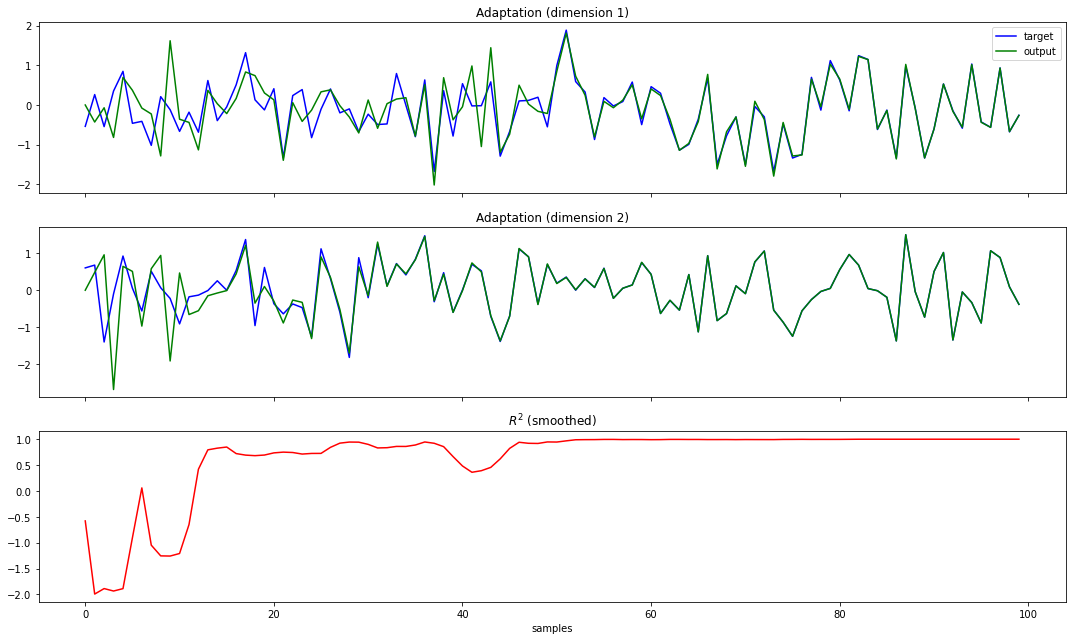

In [7]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

ax_1.set_title('Adaptation (dimension 1)')
ax_1.plot(d_vals[0, :], 'b', label='target')
ax_1.plot(y_vals[0, :], 'g', label='output')
ax_1.legend()

ax_2.set_title('Adaptation (dimension 2)')
ax_2.plot(d_vals[1, :], 'b')
ax_2.plot(y_vals[1, :], 'g')

ax_3.set_title('$R^2$ (smoothed)')
ax_3.plot(r2_ma, 'r')
ax_3.set_xlabel('samples')

plt.tight_layout()

## Test filter on synthetic vector autoregressive (VAR) process

This synthetic data is sampled from a VAR process, which allows us to use the LMS filter to predict each subsequent data point by using its recent history as input. Because this is the approach we will ultimately be using with the Steinmetz data, it makes sense to first try it on a synthetic example.

The specific VAR used below is 2-dimensional, and generates each subsequent point by applying a rotation matrix with a small angle of rotation to the previous point and adding Gaussian noise. After around 75 iterations, the LMS filter is able to accurately predict points.  

### Generate data and run filter

In [8]:
# Basic parameters
dim = 2
order = 2

# VAR parameters (TODO: Set second matrix to nonzero value!)
theta = 0.01
w_1 = 0.999 * np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])
w_2 = 0.0 * np.eye(2)
sigma = 1.0

def gen_var(n_pts):
    """Generator for VAR process."""
    
    # Initialize history values to zeros
    x_1 = np.zeros((dim, 1))
    x_2 = np.zeros((dim, 1))
    
    for i in range(n_pts):
        
        # Compute next term in sequence
        x = w_1 @ x_1 + w_2 @ x_2 + sigma * rng.normal(size=(dim, 1))
        yield x
        
        # Update history values
        x_2 = x_1
        x_1 = x

# Create LMS filter
flt = FilterAutoLMS(dim, order, mu=0.0005, wts_init='random')

# Run filter and log results
n_pts = 600
signal_gen = gen_var(n_pts)
d_vals = np.zeros((dim, n_pts))
y_vals = np.zeros((dim, n_pts))

x = np.zeros((dim, 1))
for k in range(n_pts):
    
    y = flt.predict_next(x)
    x = next(signal_gen)
    
    # Log values
    y_vals[:, k] = y.reshape(-1)
    d_vals[:, k] = x.reshape(-1)

### Compute smoothed $R^2$ values

In [9]:
# Compute intstantaneous R^2 values
r2 = compute_r2(y_vals, d_vals)

win_size = 30
r2_ma = uniform_filter1d(r2, win_size, mode='nearest')

### Plot results

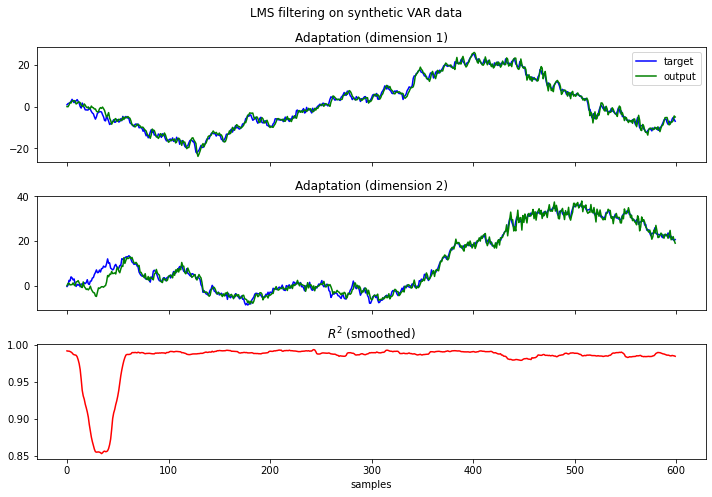

In [13]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

ax_1.set_title('Adaptation (dimension 1)')
ax_1.plot(d_vals[0, :], 'b', label='target')
ax_1.plot(y_vals[0, :], 'g', label='output')
ax_1.legend()

ax_2.set_title('Adaptation (dimension 2)')
ax_2.plot(d_vals[1, :], 'b')
ax_2.plot(y_vals[1, :], 'g')

ax_3.set_title('$R^2$ (smoothed)')
ax_3.plot(r2_ma, 'r')
ax_3.set_xlabel('samples')

plt.tight_layout()

## Test filter on Steinmetz data

Here, we test the LMS filter on the "test signal" created by concatenating trials from Steinmetz et. al's dataset (`data/processed/test_spks.h5`). The LMS filter is used in "autoregressive" mode: it attempts to find a linear filter that predicts the spike count vector at each time point from the recent history of spike count vectors. 

From the plot, it's clear that the LMS filter is not working on this dataset. There are a number of reasons why this could be the case:
  1. The spike count data might be so sparse that the filter needs to have a much higher order -- i.e. it needs to consider a longer history of spike counts -- in order to make accurate predictions. The problem with this is that, because of the relatively large number of neurons (700), increasing the order of the filter beyond 15 or so makes the computation extremely slow.
  2. The number of data points might be too small for the filter to converge, given how many parameters it has to fit.
  3. The assumed linear autoregressive model might be so far from what's actually going on in this data that even given more data and a higher-order filter, its predictive power would be extremely limited.
  
Ultimately, the fact that the LMS filter doesn't make accurate predictions on the Steinmetz data doesn't prevent us from using it to test the latency of different platforms, so this isn't a huge issue. In the long term, we will probably need to implement a more complex filter like a Kalman filter or other latent space model in order to accurately model this data.

### Load data (test signal) from file

In [11]:
data_fpath = '../data/processed/test_spks.h5'
with h5py.File(data_fpath, 'r') as f:
    spks = f['spks'][:]
    dim = spks.shape[0]

### Run filter 

In [12]:
# Set order for filter
order = 10

# Set number of points to run for
n_pts = 10000

# Learning rate
mu = 0.001

# Create LMS filter
flt = FilterLMS(dim, order, mu=mu, wts_init='zeros')

# Run filter and log results
d_vals = np.zeros((dim, n_pts))
y_vals = np.zeros((dim, n_pts))

for k in range(n_pts):
    
    t = k + order
    
    # Filter input is previous signal values
    x = spks[:, (t-order):t]
    
    # Desired filter output is next value
    d = spks[:, t].reshape(-1, 1)
    
    # Single filter step
    y = flt.predict(x)
    flt.adapt(d, x)
    
    # Log values
    d_vals[:, k] = d.reshape(-1)
    y_vals[:, k] = y.reshape(-1)

### Compute smoothed $R^2$ values

In [13]:
# Compute intstantaneous R^2 values
r2 = compute_r2(y_vals, d_vals)

# Compute Euclidean error
win_size = 20
r2_ma = uniform_filter1d(r2, win_size, mode='nearest')

### Plot results

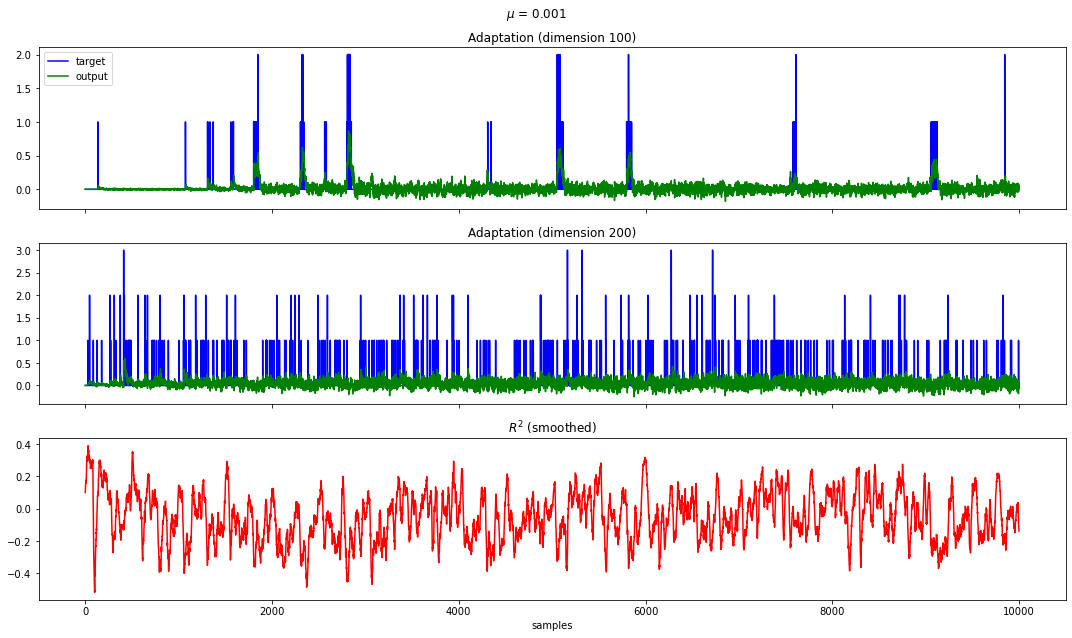

In [14]:
plot_dim_1 = 100
plot_dim_2 = 200

fig, (ax_1, ax_2, ax_3) = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

fig.suptitle(f'$\mu$ = {mu}')

ax_1.set_title(f'Adaptation (dimension {plot_dim_1})')
ax_1.plot(d_vals[plot_dim_1, :], 'b', label='target', drawstyle='steps-pre')
ax_1.plot(y_vals[plot_dim_1, :], 'g', label='output')
ax_1.legend()

ax_2.set_title(f'Adaptation (dimension {plot_dim_2})')
ax_2.plot(d_vals[plot_dim_2, :], 'b', drawstyle='steps-pre')
ax_2.plot(y_vals[plot_dim_2, :], 'g')

ax_3.set_title('$R^2$ (smoothed)')
ax_3.plot(r2_ma, 'r')
ax_3.set_xlabel('samples')

plt.tight_layout()